In [184]:
import numpy as np
import numpy.linalg as la
import cvxpy as cp
import matplotlib.pyplot as plt
import math
import random
import time
import mosek

import warnings
warnings.filterwarnings('ignore')

seed=42
random.seed(a=seed)
np.random.seed(seed=seed)

def relu(x):
    return np.maximum(0,x)
def drelu(x):
    return x>=0

In [185]:
RANDOM_STATE = 0

In [186]:
n_all = 100
N=80
d=3
def spiral_xy(i, total_points, spiral_num, n_shape = 50):
    """
    Create the data for a normalized spiral.

    Arguments:
        i runs from 0 to total_points-1.
        total_points is the total number of points in the spiral.
        spiral_num is 1 or -1.
        n_shape is an int which determines the shape of spiral wrt function, unscaled_spiral_xy.
    """
    # Normalize i to always fit in the range [0, 96], which is the original range.
    i_normalized = i * n_shape / (total_points - 1)
    φ = i_normalized / 16 * math.pi
    r = 6.5 * ((104 - i_normalized) / 104)
    x = (r * math.cos(φ) * spiral_num) / 13 + 0.5
    y = (r * math.sin(φ) * spiral_num) / 13 + 0.5  # spiral_num mirrors the orientation of the spiral
    return (x, y)


def spiral(spiral_num, n=100, n_shape = 50):
    """
    Generate either a clockwise (+1) spiral or a counter clockwise (-1) spiral for a total of n points.

    Arguments:
        spiral_num: 1 or -1 determines the orientation of the spiral.
        n: total number of points in a spiral.
    """
    return [spiral_xy(i, n, spiral_num, n_shape) for i in range(n//2)]


def generate_spiral_data(n=100, n_train = 80, n_shape = 50, seed = RANDOM_STATE, default_label = True):
    """
    Generate binary spiral classification data.

    Arguments:
        n: total number of points in a spiral.
        n_train: numbr of training points.
        seed: permutation randomization seed.
        default_label: True uses label +/-1 and False uses label 0/1
    """
    a = spiral(1,n,n_shape)
    b = spiral(-1,n,n_shape)
    # Combine spiral from both orientation as one and scaling feature space from (0,1)^2 to (-1,1)^2
    X_all=2*np.concatenate((a,b),axis=0)-1 
    X_all=np.append(X_all,np.ones((n,1)),axis=1) # Adding bias to the feature space
    # concatenate the labels of the spiral, which is their orientation (+1/-1)
    if default_label:
        y_all=np.concatenate((np.ones(n//2),-np.ones(n//2))) 
    else:
        y_all=np.concatenate((np.ones(n//2),np.zeros(n//2))) # reset -1 to 0.
    # randomize data indices
    np.random.seed(seed)
    idx = np.random.permutation(n)
    X_all = X_all[idx]
    y_all = y_all[idx]
    # Split into training and testing sets
    X_train, y_train = X_all[:n_train], y_all[:n_train]
    X_test, y_test = X_all[n_train:], y_all[n_train:]
    
    return X_all, y_all, X_train, y_train, X_test, y_test


In [187]:
X_all, y_all, X, y, Xacc, yacc = generate_spiral_data()

In [188]:
P2 = 100; P1 = 50
# sample plane arrangements
np.random.seed(RANDOM_STATE)
W1 = np.random.randn(d,P1)
W2 = np.random.randn(P1,P2)
Di = drelu(relu(X@W1)@W2).astype(int)
Qj = drelu(X@W1).astype(int)
Di=(np.unique(Di,axis=1))
Qj=(np.unique(Qj,axis=1))
P2 = Di.shape[1]
P1 = Qj.shape[1]
print(f'{P2=},{P1=}')

P2=57,P1=34


In [6]:
from matplotlib import colors as mcolors

In [8]:
# helper functions
def sort_center(c):
    c1 = {}; c2 = {}; c3 = {}; c4 = {}
    for i in range(P2):
        for j in range(P1):
            c1[(i,j)] = c[(d*P1*i+d*j):(d*P1*i+d*j+d)]
            c2[(i,j)] = c[(P2*P1*d+d*P1*i+d*j):(P2*P1*d+d*P1*i+d*j+d)]
            c3[(i,j)] = c[(P2*P1*2*d+d*P1*i+d*j):(P2*P1*2*d+d*P1*i+d*j+d)]
            c4[(i,j)] = c[(P2*P1*3*d+d*P1*i+d*j):(P2*P1*3*d+d*P1*i+d*j+d)]
    return c1, c2, c3, c4
def predict(c, i):
    c1, c2, c3, c4 = sort_center(c)
    xa = X[i,:]
    pred = 0
    for l in range(P2):
        sum_pos = 0
        sum_neg = 0
        for j in range(P1):
            sum_pos += Qj[i,j]*(xa@c1[(l,j)])-Qj[i,j]*(xa@c2[(l,j)])
            sum_neg += Qj[i,j]*(xa@c3[(l,j)])-Qj[i,j]*(xa@c4[(l,j)])
        pred += Di[i,j]*sum_pos - Di[i,j]*sum_neg
    return pred

In [9]:
def center(S,R=1):
    s = cp.Variable(4*P2*P1*d)
    obj = cp.log(R - cp.norm(s))
    constraints = []
    if len(S) > 0:
        obj += cp.sum([cp.sum(cp.log(rhs - lhs @ s)) for lhs, rhs in S])
    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve(solver=cp.MOSEK)
    return s.value

def cut(S,i):
    # inner relu constraint 
    i1 = np.kron(np.diag(2*Qj[i,:]-1),X[i,:])
    i2 = np.kron(np.eye(4*P2),i1)
    S.append((-i2,0))
    # outter relu constraint 
    o1 = np.kron(Qj[i,:],X[i,:])
    o2 = np.kron(np.diag(2*Di[i,:]-1), o1)
    o3 = np.kron(np.array([1,-1]),o2)
    o4 = np.kron(np.eye(2),o3)
    S.append((-o4,0))
    # prediction constraint 
    p1 = np.kron(Qj[i,:],X[i,:])
    p2 = np.kron(np.diag(Di[i,:]), p1)
    p3 = np.kron(np.array([1,-1,-1,1]),p2)
    S.append((-y[i]*(p3.sum(axis=0)),0))

def query(c, data_used, data_tried):
    mini = np.inf
    i_mini = -1
    maxi = -np.inf
    i_maxi = -1
    minabs = np.inf
    i_minabs = -1
    for i in range(N): 
        if (i not in data_used) and (i not in data_tried):
            pred = predict(c, i)
            if pred < mini:
                i_mini = 1*i
                mini = pred
            if pred > maxi:
                i_maxi = 1*i
                maxi = pred
            if abs(pred) < minabs:
                i_minabs = 1*i
                minabs = abs(pred) 
    return i_mini, i_maxi

In [10]:
def cutting_plane(max_iter):
    data_used = []
    data_tried = []
    plane = []
    it = 0
    while len(data_used) < N and it < max_iter:
        c = center(plane)
        i_mini, i_maxi = query(c, data_used, data_tried)
        data_tried += [i_mini, i_maxi]
        if np.sign(predict(c, i_mini)) != y[i_mini]:
            cut(plane,i_mini)
            data_used.append(i_mini)
        if np.sign(predict(c, i_maxi)) != y[i_maxi]:
            cut(plane,i_maxi)
            data_used.append(i_maxi)
        it += 1     
        print('cutting plane iteration: ', it, ' # data used: ', data_used)    
    return c, data_used

In [11]:
c = cutting_plane(20)

cutting plane iteration:  1  # data used:  [0, 0]
cutting plane iteration:  2  # data used:  [0, 0, 1]
cutting plane iteration:  3  # data used:  [0, 0, 1, 2, 55]
cutting plane iteration:  4  # data used:  [0, 0, 1, 2, 55]
cutting plane iteration:  5  # data used:  [0, 0, 1, 2, 55]
cutting plane iteration:  6  # data used:  [0, 0, 1, 2, 55]
cutting plane iteration:  7  # data used:  [0, 0, 1, 2, 55]
cutting plane iteration:  8  # data used:  [0, 0, 1, 2, 55]
cutting plane iteration:  9  # data used:  [0, 0, 1, 2, 55]
cutting plane iteration:  10  # data used:  [0, 0, 1, 2, 55, 57]
cutting plane iteration:  11  # data used:  [0, 0, 1, 2, 55, 57]
cutting plane iteration:  12  # data used:  [0, 0, 1, 2, 55, 57, 38]
cutting plane iteration:  13  # data used:  [0, 0, 1, 2, 55, 57, 38, 74]
cutting plane iteration:  14  # data used:  [0, 0, 1, 2, 55, 57, 38, 74, 36]
cutting plane iteration:  15  # data used:  [0, 0, 1, 2, 55, 57, 38, 74, 36, 20]
cutting plane iteration:  16  # data used:  [0,

In [229]:
center, used = c

In [15]:
d = 3

In [59]:
samp=100
x1=np.linspace(-1.5,1.5,samp).reshape(-1,1)
x2=np.linspace(-1.5,1.5,samp).reshape(-1,1)
Xtest=np.ones((samp**2,d))
count=0
for i in range(samp):
    for j in range(samp):
        Xtest[count]=[x1[i, 0],x2[j, 0],1]
        count+=1

In [221]:
def plot_result(Xtest, X, y, X_test, y_test, center, pos1, neg1, used, name):
    pos=np.where(y==1)
    neg=np.where(y==-1)
    def mix_with_white(color, alpha):
        white = np.array([1, 1, 1])
        return (1 - alpha) * white + alpha * np.array(color)
    # Define the original colors
    cyan = [0, 1, 1]
    magenta = [1, 0, 1]

    # Mix the colors with white
    cyan_mixed = mix_with_white(cyan, 0.3)
    magenta_mixed = mix_with_white(magenta, 0.3)

    #pred_test = predict_all(center,X_test)
    pos_test = np.where(np.sign(y_test)==1)
    neg_test = np.where(np.sign(y_test)==-1)

    X_selected = X[used]
    y_selected = y[used]

    pos_s = np.where(np.sign(y_selected)==1)
    neg_s = np.where(np.sign(y_selected)==-1)

    fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
    a1 = Xtest[pos1[0][0],0].reshape(1,Xtest[pos1[0][0],0].shape[0])
    b1 = Xtest[pos1[0][0],1].reshape(1,Xtest[pos1[0][0],1].shape[0])
    a2 = Xtest[neg1[0][0],0].reshape(1,Xtest[neg1[0][0],0].shape[0])
    b2 = Xtest[neg1[0][0],1].reshape(1,Xtest[neg1[0][0],1].shape[0])
    ax1.plot(a1,b1,'o', color=cyan_mixed)
    ax1.plot(a2,b2,'o', color=magenta_mixed)
    ax1.plot(X[pos,0],X[pos,1],'cx', marker = 'o')
    ax1.plot(X[neg,0],X[neg,1],'mx', marker = 'o')
    ax1.plot(X_test[pos_test,0],X_test[pos_test,1],'cx',marker = '^')
    ax1.plot(X_test[neg_test,0],X_test[neg_test,1],'mx',marker = '^')
    ax1.plot(X_selected[pos_s, 0], X_selected[pos_s, 1], color='cyan', marker='x')
    ax1.plot(X_selected[neg_s,0],X_selected[neg_s,1],color = 'magenta', marker = 'x')
    
    plt.savefig(f'{name}.pdf', bbox_inches='tight')

In [238]:
def plot_decision_boundary(X, y, X_test, y_test, c, selected_indices, name):
    # print train and test accuracies
    train_pred = predict_all(c, X)
    train_acc = np.mean(np.sign(train_pred) == y)
    print(f"train accuracy:{train_acc}")

    test_pred = predict_all(c, X_test)
    test_acc = np.mean(np.sign(test_pred) == y_test)
    print(f"test accuracy:{test_acc}")
    
    # Define the grid range based on the data range
    x_min, x_max = -1.5, 1.5 # 1.5
    y_min, y_max = -1.5, 1.5

    # Create a grid of points
    x1 = np.linspace(x_min, x_max, 100)
    x2 = np.linspace(y_min, y_max, 100)
    x1, x2 = np.meshgrid(x1, x2)
    Xtest = np.c_[x1.ravel(), x2.ravel()]
    Xtest = np.append(Xtest, np.ones((Xtest.shape[0], 1)), axis=1)  # Add the bias term

    yest_cvx = predict_all(c, Xtest)
    yest_cvx = yest_cvx.reshape(x1.shape)
    
    # Map labels back to -1 and 1 for visualization
    y_train_mapped = np.where(y == 1, 1, -1)
    y_test_mapped = np.where(y_test == 1, 1, -1)
    
    X_selected = X[selected_indices]
    y_selected = y_train_mapped[selected_indices]

    # Create subplots
    fig, ax = plt.subplots(figsize=(7, 7))

    # Define the custom colors
    colors = ['#920783', '#00b7c7']  # Switched the colors to match the image
    cmap = mcolors.ListedColormap(colors)

    # Plot the decision boundary with custom colors
    ax.contourf(x1, x2, yest_cvx, alpha=0.3, cmap=cmap)
    scatter_train = ax.scatter(X[:, 0], X[:, 1], c=y_train_mapped, edgecolor='k', s=20, cmap=cmap,
                               label='Train Data')
    scatter_test = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test_mapped, edgecolor='k', s=20, cmap=cmap,
                              marker='^', label = 'Test Data')
    scatter_select = ax.scatter(X_selected[:,0], X_selected[:,1], c=y_selected, s=80, cmap=cmap, marker='x',
                               label='Queried Data')
    
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f'{name}')
    plt.legend()
    plt.savefig(f'{name}.pdf', bbox_inches='tight')
    plt.show()

train accuracy:0.7125
test accuracy:0.6


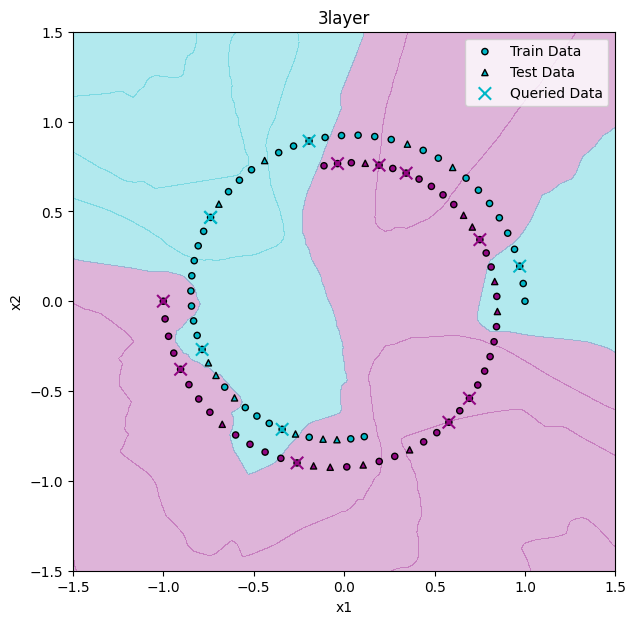

In [239]:
plot_decision_boundary(X, y, Xacc, yacc, center, used, '3layer')

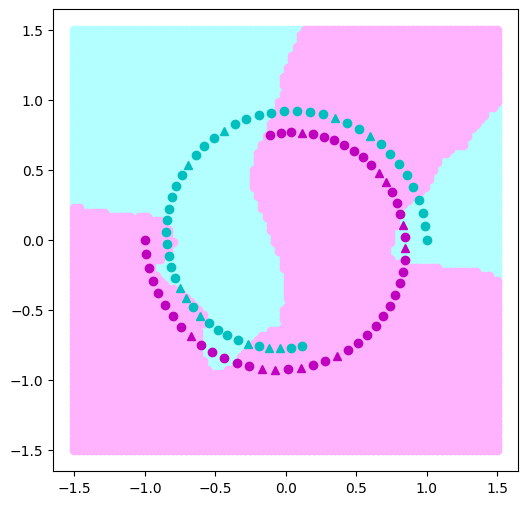

In [219]:
def predict_all(c, Xtest):
    c1, c2, c3, c4 = sort_center(c)
    pred = 0
    for i in range(P2):
        sum_pos = 0
        sum_neg = 0
        for j in range(P1):
            sum_pos += relu(Xtest@c1[(i,j)])-relu(Xtest@c2[(i,j)])
            sum_neg += relu(Xtest@c3[(i,j)])-relu(Xtest@c4[(i,j)])
        pred += relu(sum_pos) - relu(sum_neg)
    return pred 
pred = predict_all(center,Xtest)
pos = []; neg = []
pos.append(np.where(np.sign(pred)==1))
neg.append(np.where(np.sign(pred)==-1))
plot_result(Xtest, X, y, Xacc, yacc, center, pos, neg, used, 'aaa')
#plot_result(Xtest, pos, neg, 'aaa')
#plot_result(X, y, Xacc, yacc,pred,used, 'aaa')
# plot_result(Xtest, pos, neg, 'aaa', pred, X, y)